In [16]:
import pandas as pd
import numpy as np
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt


df=pd.read_csv('bank_marketing.csv')

# splittng the datatable to three relevant tables 
client=df[['client_id', 'age', 'job', 'marital','education', 'credit_default',
       'housing','loan']].copy()
campaign=df[['client_id','campaign','duration','pdays','previous','poutcome','y']].copy()

economics=df[['client_id','emp_var_rate','cons_price_idx','euribor3m','nr_employed']].copy()


#  replacing the columns name with better names 
campaign.loc['campaign_id'] = 1
column_rename_client = {'client_id': 'id'}
column_rename_campaign= {'duration': 'contact_duration', 'previous': 'previous_campaign_contacts', 'y': 'campaign_outcome', 'poutcome': 'previous_outcome', 'campaign': 'number_contacts'}
column_rename_economics = {'euribor3m': 'euribor_three_months','nr_employed': 'number_employed'}

client.rename(columns=column_rename_client, inplace=True)
campaign.rename(columns=column_rename_campaign, inplace=True)
economics.rename(columns=column_rename_economics, inplace=True)


#  cleaning data
client['education'] = client['education'].str.replace('.','_', regex=False) #replace . with _
client['education'] = client['education'].replace('unknown',np.nan, regex=False)
client['job'] = client['job'].str.replace('.', '', regex=False)

outcomes_replace={'success':'1','failure':'0','nonexistent':np.nan }
campaign['previous_outcome'] = campaign['previous_outcome'].replace(outcomes_replace)

#  improving the date column  by converting to the datetime format 
df['year']='2022'
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

df['month'] = df['month'].map(month_mapping)
campaign['last_contact_date'] =pd.to_datetime(df[['year', 'month','day']]).dt.strftime('%Y-%m-%d')

# create new column for contact duration in minutes 
campaign['contact_duration_in_minutes']=round(campaign['contact_duration']/60,2)



#this was done to complete the connection with sql database managment 
# replacing nan values with 2 as they not affect the analysis results 
campaign.previous_outcome.fillna(2, inplace=True)
campaign.drop(campaign.index[-1], inplace=True)

# conver to csv files 
# onw time to be created is enough
# client.to_csv('client.csv', index=False)
# campaign.to_csv('campaign.csv', index=False)
# economics.to_csv('economics.csv', index=False)


# Define connection parameters
server = 'HUNTER\SQLEXPRESS'
database = 'banks_database'


                                    ################# connectoin to sql server###########
# Create a connection string
connection_string = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"Trusted_Connection=yes;"
   
)

# Establish a connection
try:
    conn = pyodbc.connect(connection_string)
    print("Connected to SQL Server")
except Exception as e:
    print(f"Error: {str(e)}")







Connected to SQL Server


In [2]:

# SQL statements for table creation
client_table_sql = """
CREATE TABLE client
(
    id  INT PRIMARY KEY,
    age INT,
    job NVARCHAR(255),
    marital NVARCHAR(255),
    education NVARCHAR(255),
    credit_default NVARCHAR(255),
    housing NVARCHAR(255),
    loan NVARCHAR(255)
);
"""
campaign_table_sql = """
CREATE TABLE campaign (
    campaign_id INT IDENTITY(1,1) PRIMARY KEY,
    client_id INT,
    number_contacts INT,
    contact_duration INT,
    pdays INT,
    previous_campaign_contacts INT,
    previous_outcome INT ,  
    campaign_outcome BIT,
    last_contact_date DATE
);
"""

economics_table_sql = """
CREATE TABLE economics (
    client_id INT REFERENCES client (id),
    emp_var_rate FLOAT,
    cons_price_idx FLOAT,
    euribor_three_months FLOAT,
    number_employed FLOAT
);
"""


try:
    cursor = conn.cursor()
    
    # once you create the tables, no need to run and execute this again      
    # Execute the CREATE TABLE statements
    
    # cursor.execute(client_table_sql)
    # cursor.execute(campaign_table_sql)
    # cursor.execute(economics_table_sql)
    
    print("Tables 'client' and 'campaign' vs economics created successfully.")
    
    # Commit the table creation transactions
    conn.commit()
    
except Exception as e:
    print(f"Error: {str(e)}")   



Tables 'client' and 'campaign' vs economics created successfully.


In [3]:
# Execute the SQL statements
try:
    cursor = conn.cursor()
    
    # Now, copy data from 'client.csv' and 'campaign.csv'
    copy_data_sql = """
    BULK INSERT client
    FROM 'C:/Users/moham/OneDrive/Desktop/for_now/client.csv'
    WITH (
        FORMAT = 'CSV',
        FIRSTROW = 2,  -- Skip the header row
        FIELDTERMINATOR = ',',
        ROWTERMINATOR = '\n'
    );
    """
    
    
    
    copy_data_sql1 = """
    BULK INSERT campaign
    FROM 'C:/Users/moham/OneDrive/Desktop/for_now/campaign.csv'
    WITH (
        FORMAT = 'CSV',
        FIRSTROW = 2,  -- Skip the header row
        FIELDTERMINATOR = ',',
        ROWTERMINATOR = '0x0a'
    );
    """
    
    
    
    copy_econimcs_data = """
    BULK INSERT economics
    FROM 'C:/Users/moham/OneDrive/Desktop/for_now/economics.csv'
    WITH (
        FORMAT = 'CSV',
        FIRSTROW = 2,  -- Skip the header row
        FIELDTERMINATOR = ',',
        ROWTERMINATOR = '0x0a'
    );
    """
    
#     cope the data just one time
# no need to copy the same data every time code run
    # Execute the data copy statements
    # cursor.execute(copy_data_sql)
    # cursor.execute(copy_data_sql1)
    # cursor.execute(copy_econimcs_data)
    
    print("Data copied from csv files to sql tables")
    
    
    # Commit the transaction again
    conn.commit()
    
except Exception as e:
    print(f"Error: {str(e)}")

# Close the connection
conn.close()




    






Data copied from csv files to sql tables


In [4]:
# dropping nulls from education column

client.dropna(subset=['education'], inplace=True)
print(f"the number of nan values in education coulmn is {client.education.isna().sum()}")
client.education.unique()

the number of nan values in education coulmn is 0


array(['basic_4y', 'high_school', 'basic_6y', 'basic_9y',
       'professional_course', 'university_degree', 'illiterate'],
      dtype=object)

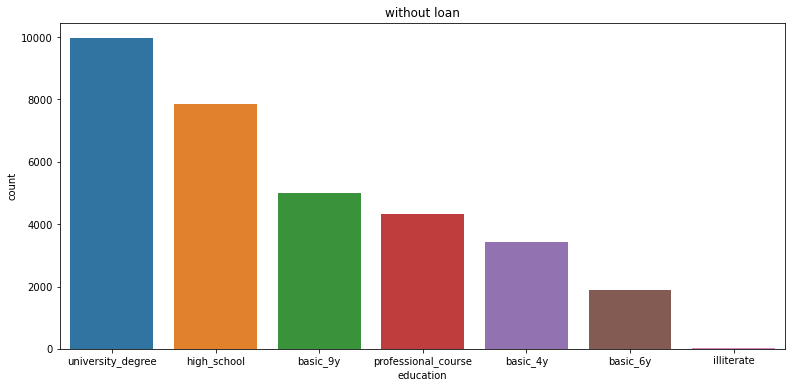

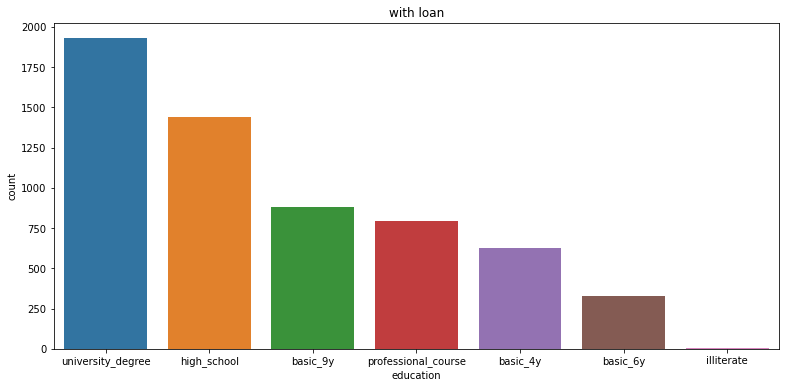

In [6]:
# is there any diffrence in taking loans between poeple with high education and people without it 

with_loan_df= client[client['loan']=='yes']
without_loan_df= client[client['loan']=='no']


plt.figure(figsize=(13, 6))
plt.title('without loan')
sns.countplot(data=without_loan_df, x='education',order=without_loan_df['education'].value_counts().index)
plt.show()

plt.figure(figsize=(13, 6))
plt.title('with loan')
sns.countplot(data=with_loan_df, x='education', order=with_loan_df['education'].value_counts().index)
plt.show()


In [7]:
print('with loan')
print(with_loan_df.education.value_counts())
print('without')
print(without_loan_df.education.value_counts())

with loan
university_degree      1930
high_school            1443
basic_9y                883
professional_course     793
basic_4y                624
basic_6y                330
illiterate                3
Name: education, dtype: int64
without
university_degree      9961
high_school            7852
basic_9y               5011
professional_course    4325
basic_4y               3435
basic_6y               1902
illiterate               15
Name: education, dtype: int64


In [8]:
                                                             ##working just with the clients who participated in the campaign## 


participate_id = campaign[campaign['campaign_outcome'] == 'yes']['client_id']

# Corrected the variable name in the next line
participate_client = client[client['id'].isin(participate_id)]

# Display the result
participate_client.head()


,id,age,job,marital,education,credit_default,housing,loan
75,75,41,blue-collar,divorced,basic_4y,unknown,yes,no
83,83,49,entrepreneur,married,university_degree,unknown,yes,no
88,88,49,technician,married,basic_9y,no,no,no
129,129,41,technician,married,professional_course,unknown,yes,no
139,139,45,blue-collar,married,basic_9y,unknown,yes,no


In [19]:

                                                   # printing some information about the particibated people# 
print(f"the average age of people participated in the campign is {participate_client.age.mean()}")
print(f"the most frequant job for people participated in the campign is { participate_client.job.value_counts().idxmax() }")
print(f"people participated in the campign were mostly {participate_client.marital.value_counts().idxmax()}")
print(f" {round(len(participate_client[participate_client['loan'] == 'yes'])/len(participate_client),3)} of the participated people in the campign are on loan   ")
campaign.head()

the average age of people participated in the campign is 40.72408293460925
the most frequant job for people participated in the campign is admin
people participated in the campign were mostly married
 0.146 of the participated people in the campign are on loan   


,client_id,number_contacts,contact_duration,pdays,previous_campaign_contacts,previous_outcome,campaign_outcome,last_contact_date,contact_duration_in_minutes
0,0,1,261,999,0,2,no,2022-05-13,4.35
1,1,1,149,999,0,2,no,2022-05-19,2.48
2,2,1,226,999,0,2,no,2022-05-23,3.77
3,3,1,151,999,0,2,no,2022-05-27,2.52
4,4,1,307,999,0,2,no,2022-05-03,5.12


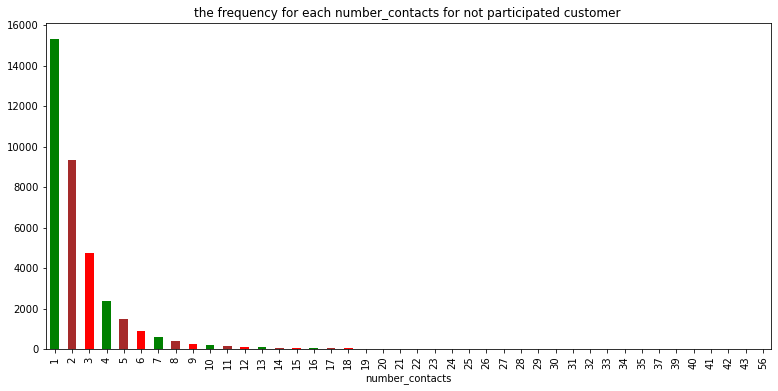

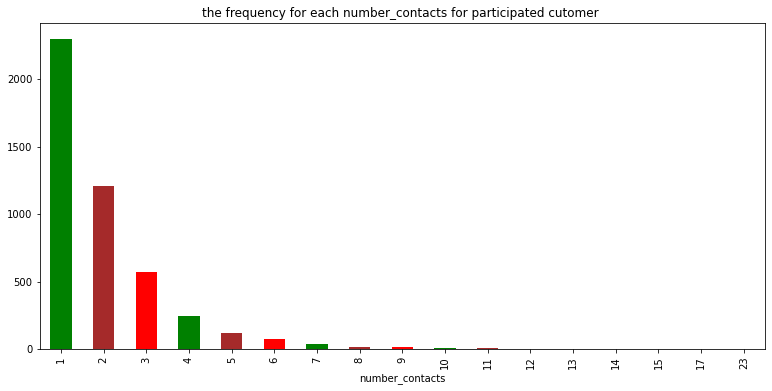

In [40]:
# working with campaign table

yes_participated=campaign[campaign['campaign_outcome']=='yes']
no_participated=campaign[campaign['campaign_outcome']=='no']




grouped_no_data=no_participated.groupby('number_contacts')['campaign_outcome'].count()
grouped_yes_data=yes_participated.groupby('number_contacts')['campaign_outcome'].count()

grouped_no_data.plot(kind='bar', color=['green', 'brown','red'],figsize=(13, 6))
plt.title('the frequency for each number_contacts for not participated customer ')
plt.show()

# most of the participated subscribed from the first contact 
# as we look at this graph its apear that there is a negative relationship between values ,, but does this means that there is no any effect of the number_contacts on
# the campaign outcome 
grouped_yes_data.plot(kind='bar', color=['green', 'brown','red'],figsize=(13, 6))
plt.title('the frequency for each number_contacts for participated cutomer ')
plt.show()
